In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from math import sqrt
import dtale
import utils
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [3]:
df = pd.read_csv("../heart.csv")
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)
df_encoded = df_encoded[df_encoded['RestingBP'] != 0]
df_encoded = df_encoded[df_encoded['Cholesterol'] != 0]

In [4]:
quantitative_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
df_mixte = df_encoded
df_mixte_num = df_encoded[quantitative_cols]

# Petit nettoyage des outliers

In [5]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(contamination='auto', random_state=42)
predictions_mixte = clf.fit_predict(df_mixte_num)
df_mixte['outlier'] = predictions_mixte
df_cleaned_mixte = df_mixte[df_mixte['outlier'] == 1].copy().drop(columns=['outlier'])
X_cleaned_mixte = df_cleaned_mixte[quantitative_cols]
print(f"Nombre de points avant nettoyage : {len(df_mixte)}")
print(f"Nombre d'outliers détectés : {len(df_mixte[df_mixte['outlier'] == -1])}")
print(f"Nombre de points après nettoyage : {len(df_cleaned_mixte)}")

Nombre de points avant nettoyage : 746
Nombre d'outliers détectés : 118
Nombre de points après nettoyage : 628


# Calcul des scores AD HOC et Silhouette pour TSNE


------ Calcul du t-SNE (cela peut prendre quelques secondes) ------

------ 2. Recherche du nombre optimal de clusters (k)... ------

=== Résultats pour covariance = full  ===
   K (clusters)  Log-vraisemblance (Ad-hoc)  Silhouette
0             2                      -7.938       0.496
1             3                      -7.905       0.365
2             4                      -7.865       0.388
3             5                      -7.801       0.383
4             6                      -7.793       0.332
5             7                      -7.747       0.344
6             8                      -7.763       0.376
7             9                      -7.684       0.346
8            10                      -7.679       0.349


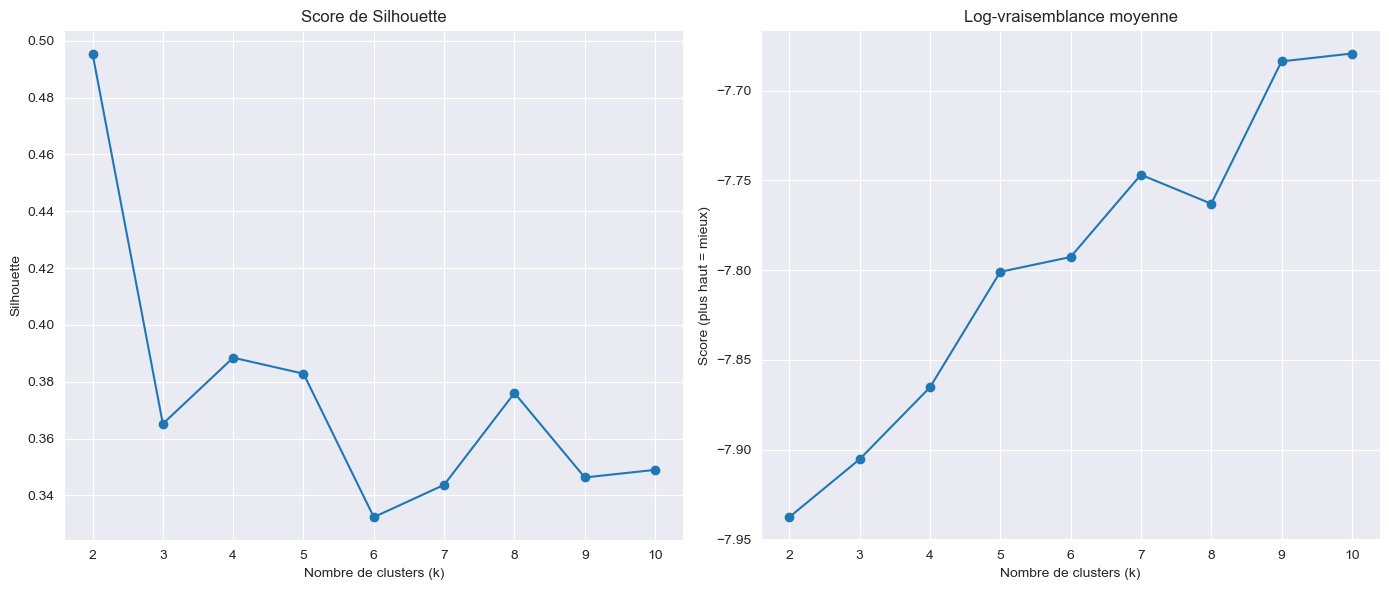


=== Résultats pour covariance = tied  ===
   K (clusters)  Log-vraisemblance (Ad-hoc)  Silhouette
0             2                      -7.947       0.496
1             3                      -7.925       0.365
2             4                      -7.912       0.373
3             5                      -7.859       0.381
4             6                      -7.834       0.367
5             7                      -7.821       0.358
6             8                      -7.810       0.384
7             9                      -7.788       0.390
8            10                      -7.765       0.389


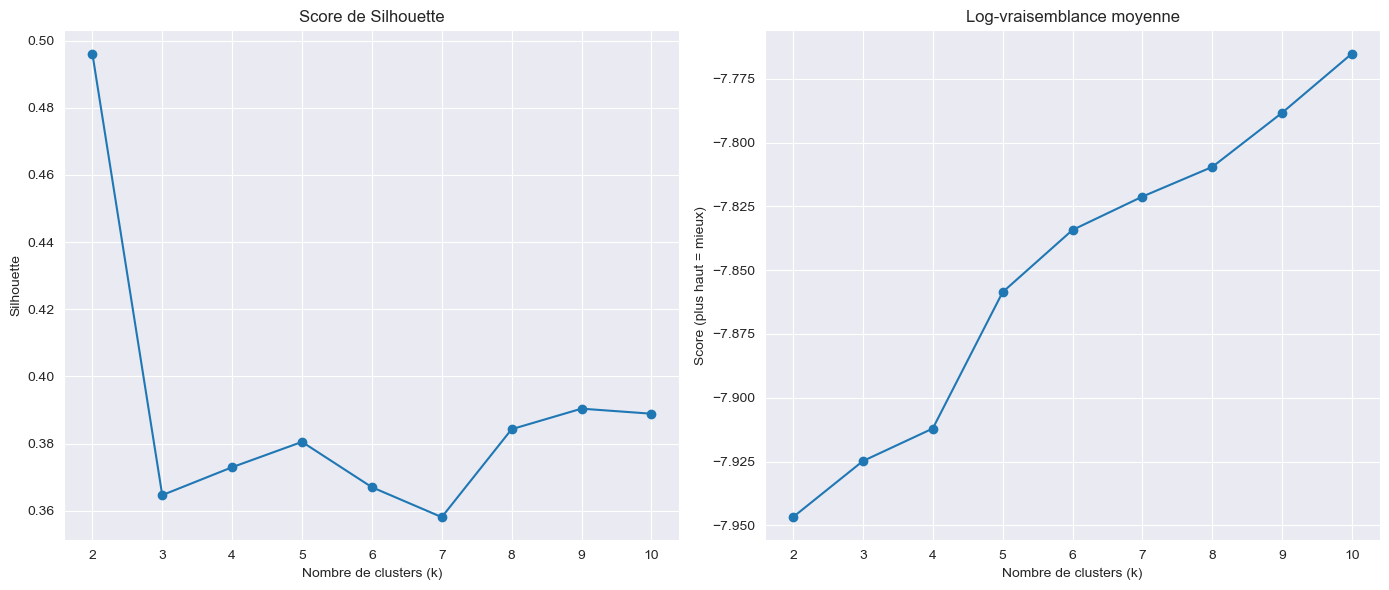


=== Résultats pour covariance = diag  ===
   K (clusters)  Log-vraisemblance (Ad-hoc)  Silhouette
0             2                      -7.943       0.496
1             3                      -7.911       0.366
2             4                      -7.878       0.397
3             5                      -7.819       0.381
4             6                      -7.818       0.323
5             7                      -7.814       0.325
6             8                      -7.776       0.380
7             9                      -7.736       0.360
8            10                      -7.714       0.361


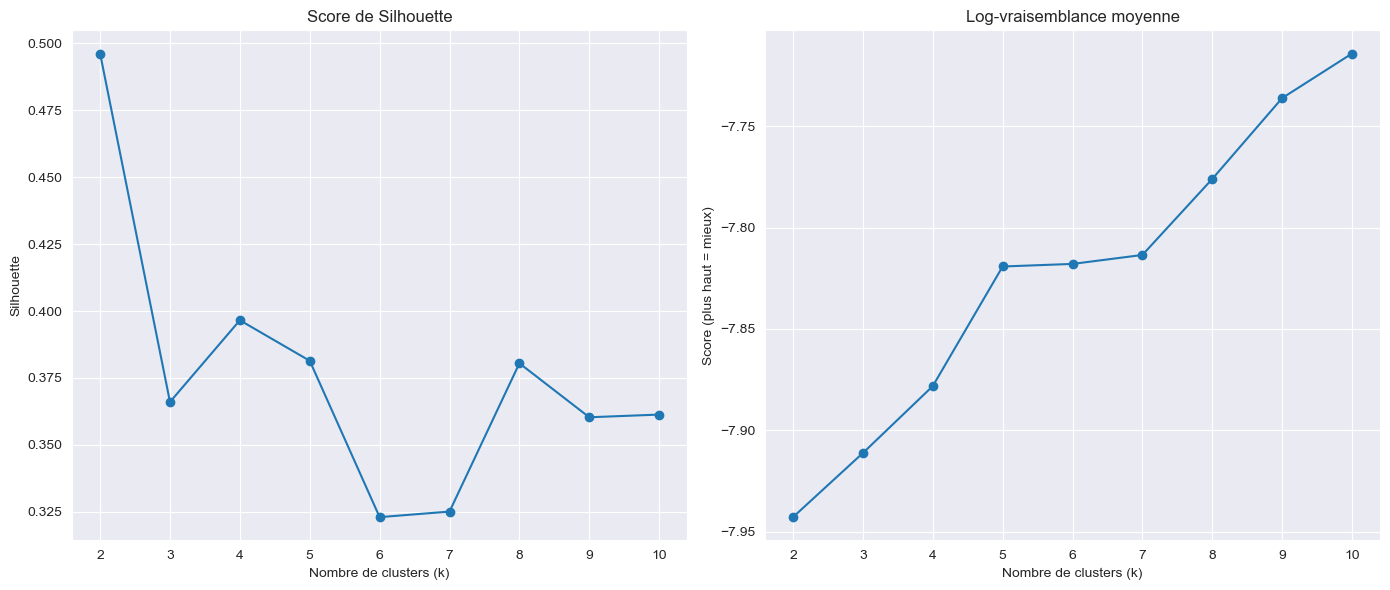


=== Résultats pour covariance = spherical  ===
   K (clusters)  Log-vraisemblance (Ad-hoc)  Silhouette
0             2                      -7.943       0.495
1             3                      -7.929       0.362
2             4                      -7.894       0.386
3             5                      -7.873       0.400
4             6                      -7.877       0.320
5             7                      -7.841       0.333
6             8                      -7.786       0.378
7             9                      -7.753       0.380
8            10                      -7.738       0.378


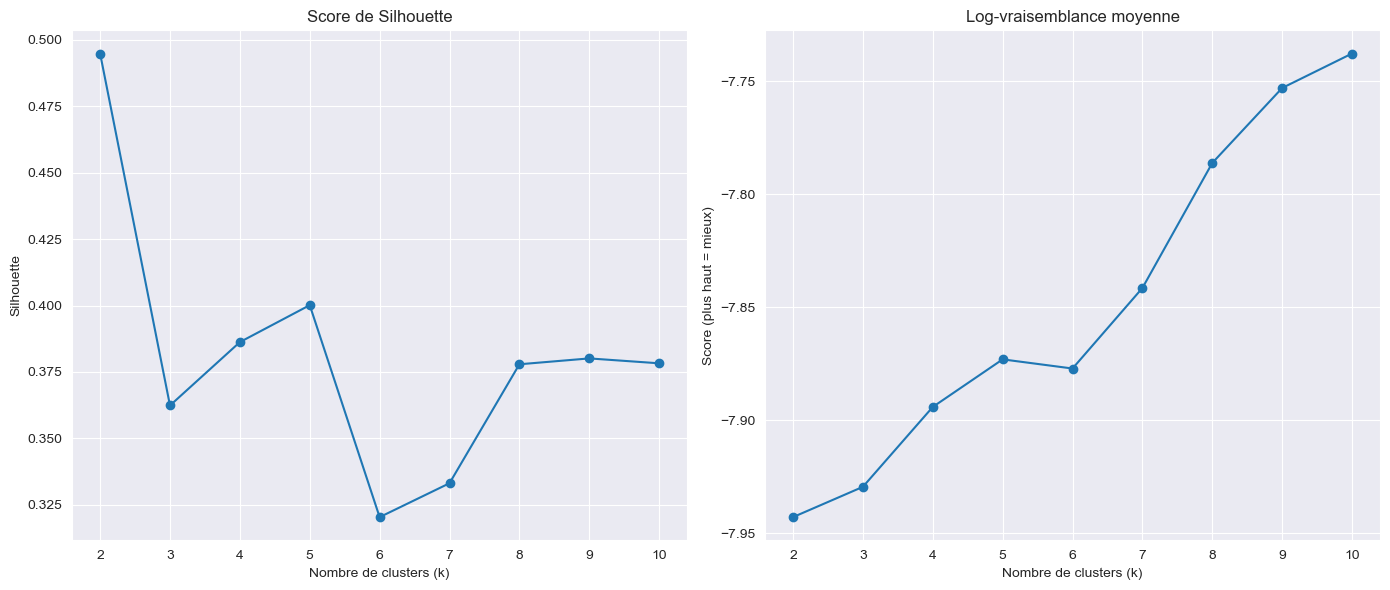

In [15]:

# ======================================================================
ct = ColumnTransformer([
    ("num", StandardScaler(), quantitative_cols)
], remainder='drop')

X_norm = ct.fit_transform(df_cleaned_mixte)

# ======================================================================
print("\n------ Calcul du t-SNE (cela peut prendre quelques secondes) ------")

X_tsne_mixte = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate='auto',
    init='pca',
    random_state=42
).fit_transform(X_norm)

# ======================================================================

print("\n------ 2. Recherche du nombre optimal de clusters (k)... ------")
covariances_types = ["full", "tied", "diag", "spherical"]

for covariance_type in covariances_types:
    n_components_range = range(2, 11)  # silhouette pas défini pour k=1


    silhouette_scores = []
    ad_hoc_scores = []

    for n_components in n_components_range:
        gmm = GaussianMixture(
            n_components=n_components,
            covariance_type=covariance_type,
            random_state=42
        )
        gmm.fit(X_tsne_mixte)

        # --- Score ad hoc (log-vraisemblance moyenne)
        ad_hoc = gmm.score(X_tsne_mixte)
        ad_hoc_scores.append(ad_hoc)

        # --- Silhouette
        labels = gmm.predict(X_tsne_mixte)
        silhouette_scores.append(silhouette_score(X_tsne_mixte, labels))

    # Tableau résumé
    results_df = pd.DataFrame({
        "K (clusters)": n_components_range,
        "Log-vraisemblance (Ad-hoc)": ad_hoc_scores,
        "Silhouette": silhouette_scores
    })

    print("\n=== Résultats pour covariance =", covariance_type, " ===")
    print(results_df.round(3))


    # ==================================================================
    plt.figure(figsize=(14, 6))

    # Score de Silhouette
    plt.subplot(1, 2, 1)
    plt.plot(n_components_range, silhouette_scores, marker='o')
    plt.title("Score de Silhouette")
    plt.xlabel("Nombre de clusters (k)")
    plt.ylabel("Silhouette")
    plt.grid(True)

    # Log-vraisemblance Ad-hoc
    plt.subplot(1, 2, 2)
    plt.plot(n_components_range, ad_hoc_scores, marker='o')
    plt.title("Log-vraisemblance moyenne")
    plt.xlabel("Nombre de clusters (k)")
    plt.ylabel("Score (plus haut = mieux)")
    plt.grid(True)

    plt.tight_layout()
    #plt.savefig(f"figure/ADHOC_SILH_GMM_TSNE_{covariance_type}.png", dpi=300, bbox_inches='tight')
    plt.show()


# Calcul AD HOC Et Silhouette pour PCA


------ 2. Recherche du nombre optimal de clusters (k)... ------

=== Tableau comparatif des scores (Ad-hoc, Silhouette) ===
   K (clusters)  Log-vraisemblance moyenne (Ad-hoc)  Silhouette
0             2                              -3.113       0.388
1             3                              -3.095       0.335
2             4                              -3.082       0.348
3             5                              -3.076       0.345
4             6                              -3.071       0.341
5             7                              -3.065       0.333
6             8                              -3.043       0.328
7             9                              -3.039       0.322
8            10                              -3.040       0.325


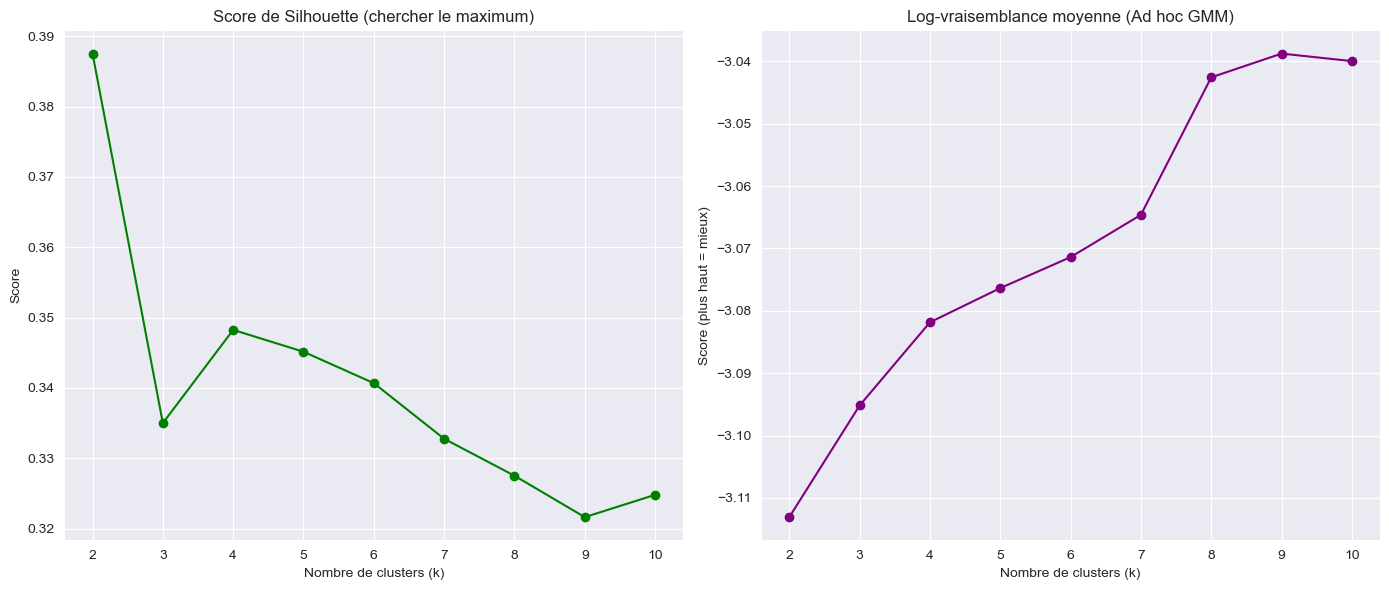


=== Tableau comparatif des scores (Ad-hoc, Silhouette) ===
   K (clusters)  Log-vraisemblance moyenne (Ad-hoc)  Silhouette
0             2                              -3.117       0.386
1             3                              -3.116       0.326
2             4                              -3.095       0.332
3             5                              -3.091       0.340
4             6                              -3.088       0.341
5             7                              -3.086       0.328
6             8                              -3.077       0.335
7             9                              -3.079       0.327
8            10                              -3.071       0.301


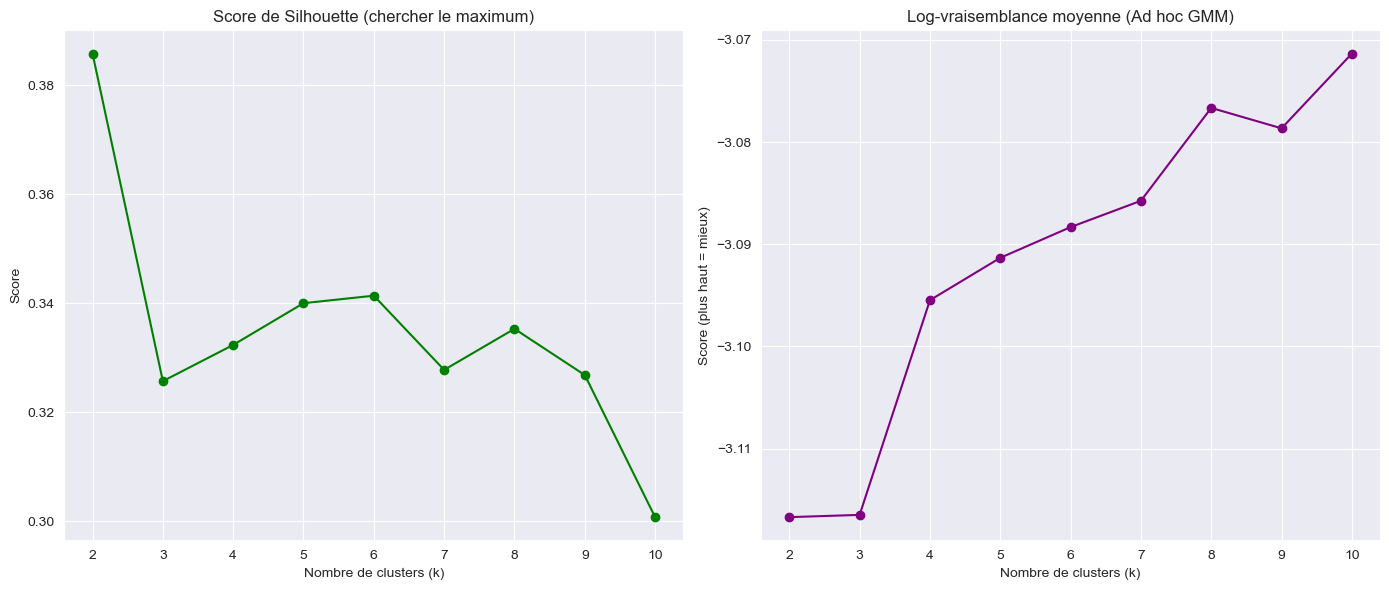


=== Tableau comparatif des scores (Ad-hoc, Silhouette) ===
   K (clusters)  Log-vraisemblance moyenne (Ad-hoc)  Silhouette
0             2                              -3.115       0.384
1             3                              -3.107       0.350
2             4                              -3.090       0.346
3             5                              -3.079       0.342
4             6                              -3.076       0.344
5             7                              -3.071       0.334
6             8                              -3.053       0.337
7             9                              -3.050       0.329
8            10                              -3.051       0.309


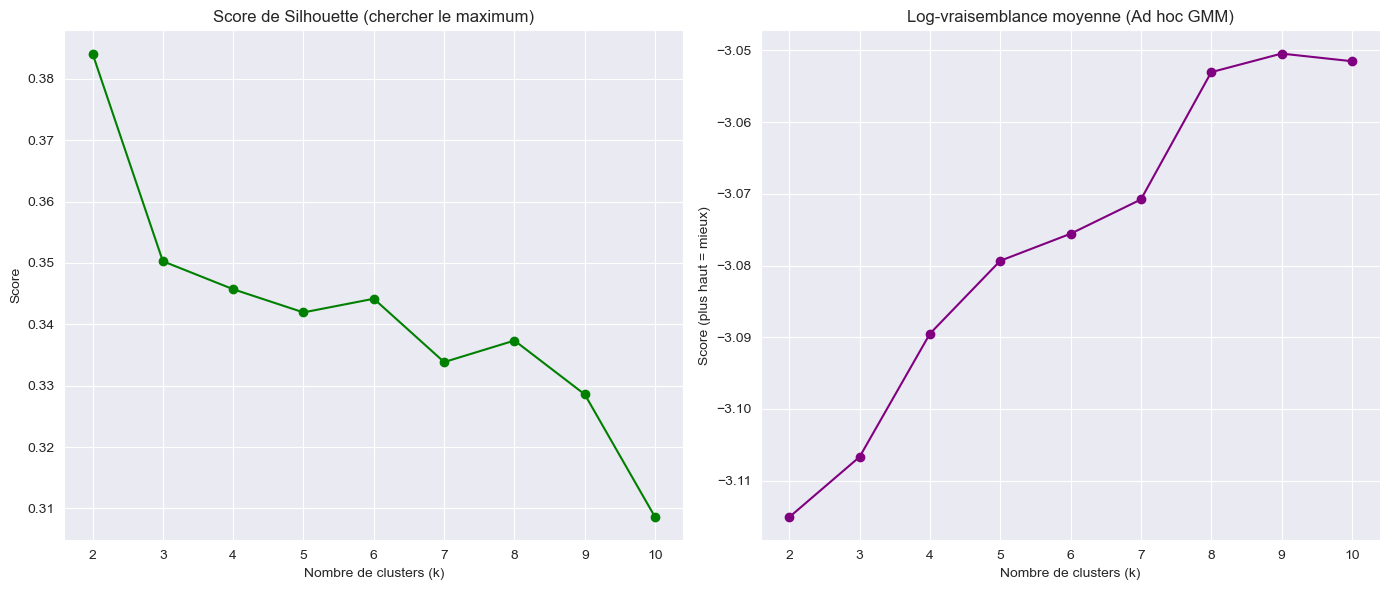


=== Tableau comparatif des scores (Ad-hoc, Silhouette) ===
   K (clusters)  Log-vraisemblance moyenne (Ad-hoc)  Silhouette
0             2                              -3.117       0.383
1             3                              -3.112       0.326
2             4                              -3.094       0.350
3             5                              -3.088       0.344
4             6                              -3.080       0.351
5             7                              -3.080       0.330
6             8                              -3.057       0.326
7             9                              -3.057       0.321
8            10                              -3.058       0.314


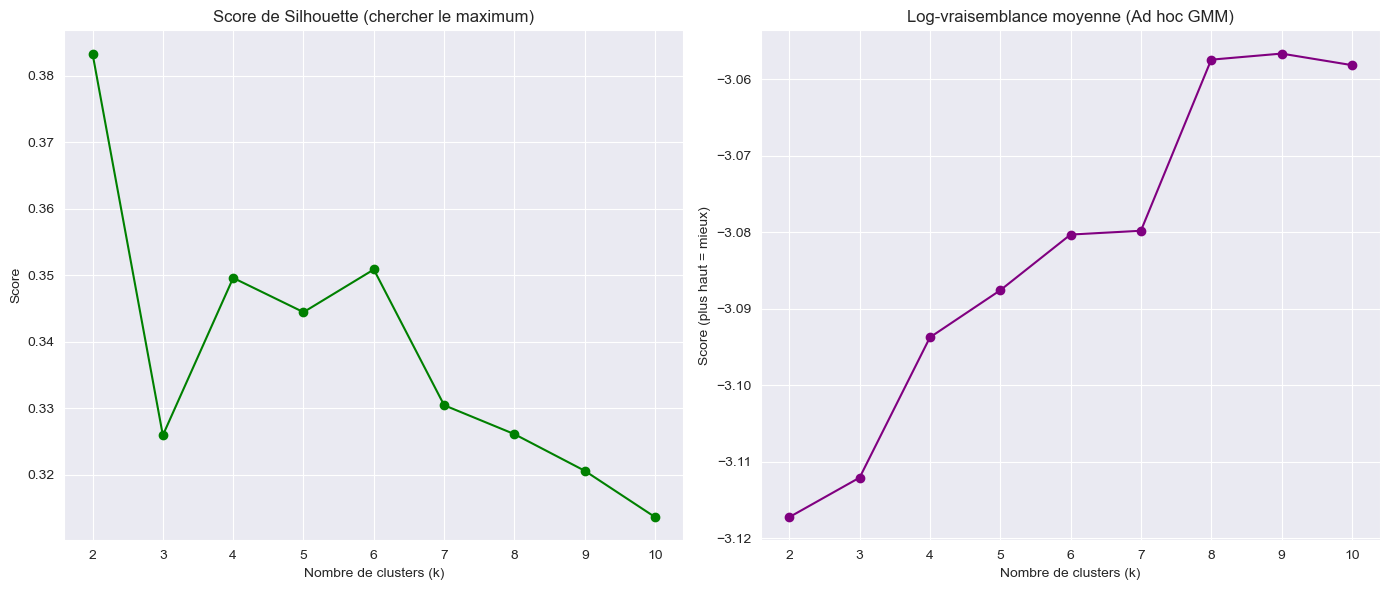

In [16]:
# PCA en 2 dimensions
X_pca_mixte = PCA(n_components=2).fit_transform(X_norm)

# ==============================================================================

print("\n------ 2. Recherche du nombre optimal de clusters (k)... ------")
covariances_types = ["full", "tied", "diag", "spherical"]
for covariance_type in covariances_types:
    n_components_range = range(2, 11)

    silhouette_scores = []
    ad_hoc_scores = []

    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components,covariance_type=covariance_type, random_state=42)
        gmm.fit(X_pca_mixte)

        # --- AD-HOC SCORE : log-vraisemblance moyenne ---
        ad_hoc = gmm.score(X_pca_mixte)
        ad_hoc_scores.append(ad_hoc)


        # --- Score de silhouette ---
        labels = gmm.predict(X_pca_mixte)
        silhouette = silhouette_score(X_pca_mixte, labels)
        silhouette_scores.append(silhouette)
    # ==============================================================================
    results_df = pd.DataFrame({
        "K (clusters)": n_components_range,
        "Log-vraisemblance moyenne (Ad-hoc)": ad_hoc_scores,
        "Silhouette": silhouette_scores
    })

    print("\n=== Tableau comparatif des scores (Ad-hoc, Silhouette) ===")
    print(results_df.round(3))

    # ==============================================================================

    plt.figure(figsize=(14, 6))
    # --- Graphique Silhouette ---
    plt.subplot(1, 2, 1)
    plt.plot(n_components_range, silhouette_scores, marker='o', color='green')
    plt.title("Score de Silhouette (chercher le maximum)")
    plt.xlabel("Nombre de clusters (k)")
    plt.ylabel("Score")
    plt.grid(True)
    #plt.savefig("figure/Silhouette_GMM.png", dpi=300, bbox_inches='tight')

    # --- Graphique Log-vraisemblance (Ad hoc) ---
    plt.subplot(1, 2, 2)
    plt.plot(n_components_range, ad_hoc_scores, marker='o', color='purple')
    plt.title("Log-vraisemblance moyenne (Ad hoc GMM)")
    plt.xlabel("Nombre de clusters (k)")
    plt.ylabel("Score (plus haut = mieux)")
    plt.grid(True)
    #plt.savefig(f"figure/AD-HOC_SILH_GMM_{covariance_type}.png", dpi=300, bbox_inches='tight')

    plt.tight_layout()
    plt.show()

# Visualisation des clusters avec GMM (1 kernel avec TSNE et 2ème avec PCA)

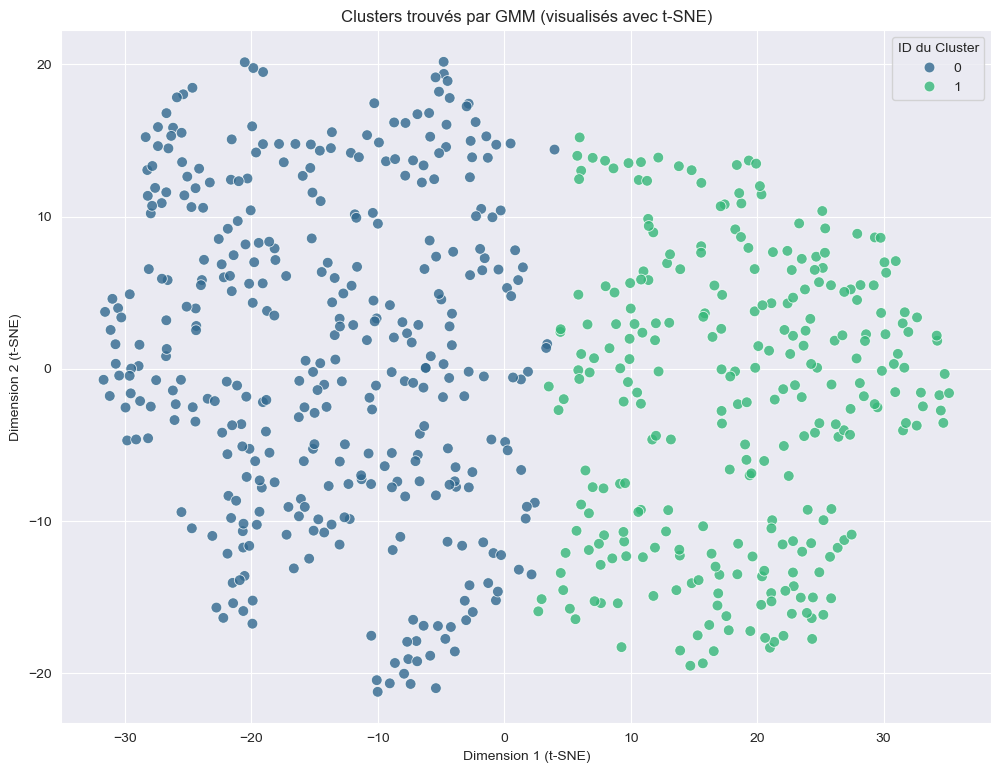

In [18]:
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(X_tsne_mixte)

labels = gmm.predict(X_tsne_mixte)

# Création du DataFrame pour la visualisation
df_tsne_mixte = pd.DataFrame(data=X_tsne_mixte, columns=['Dim1', 'Dim2'])
df_tsne_mixte['cluster'] = labels

# Visualisation t-SNE
plt.figure(figsize=(12, 9))
sns.scatterplot(
    x='Dim1', y='Dim2', hue='cluster',
    data=df_tsne_mixte, palette='viridis', s=60, alpha=0.8
)
plt.title('Clusters trouvés par GMM (visualisés avec t-SNE)')
plt.xlabel('Dimension 1 (t-SNE)')
plt.ylabel('Dimension 2 (t-SNE)')
plt.legend(title='ID du Cluster')
plt.grid(True)
#plt.savefig("figure/TSNE_GMM.png", dpi=300, bbox_inches='tight')
plt.show()


# Visualisation des moyennes et écart-type des clusters pour les valeurs continues

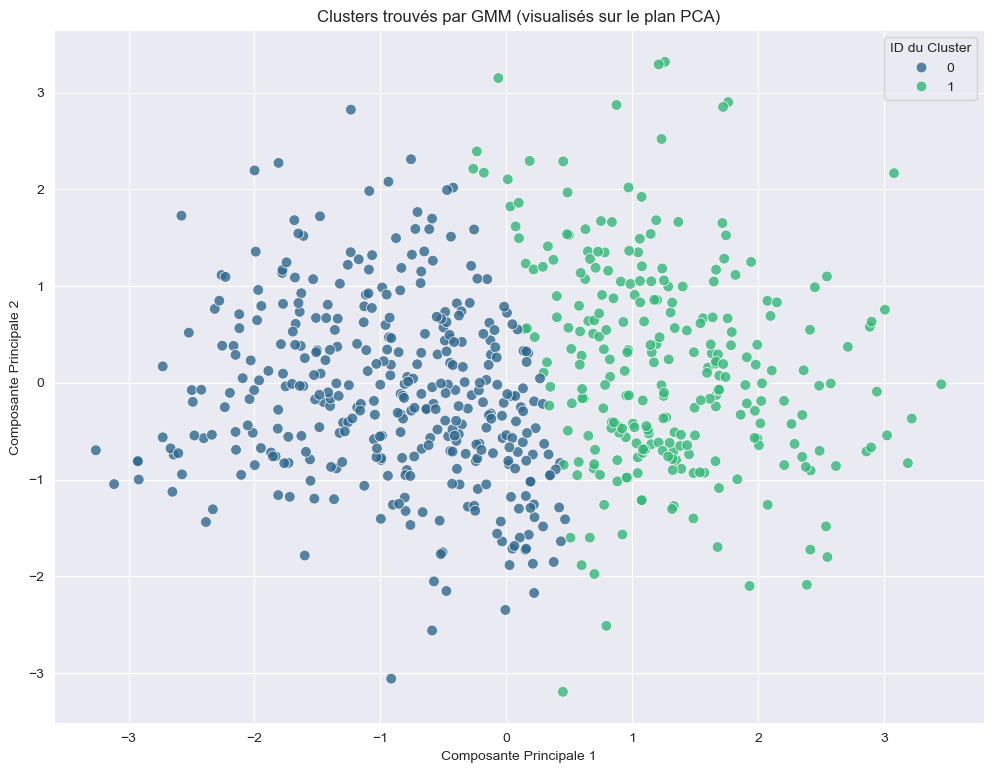

In [19]:
# GMM sur les données PCA
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(X_pca_mixte)

labels = gmm.predict(X_pca_mixte)

# DataFrame pour la visualisation
df_viz_mixte = pd.DataFrame(data=X_pca_mixte, columns=['CP1', 'CP2'])
df_viz_mixte['cluster'] = labels

# Visualisation
plt.figure(figsize=(12, 9))
sns.scatterplot(
    x='CP1', y='CP2', hue='cluster',
    data=df_viz_mixte, palette='viridis', s=60, alpha=0.8
)
plt.title('Clusters trouvés par GMM (visualisés sur le plan PCA)')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.legend(title='ID du Cluster')
plt.grid(True)
#plt.savefig("figure/PCA_GMM.png", dpi=300, bbox_inches='tight')
plt.show()


# Analyse des clusters sur les valeurs continues

In [20]:
# Ajouter la colonne cluster
df_clusters = X_cleaned_mixte.copy()
df_clusters['cluster'] = labels

# Moyennes par cluster
cluster_means = df_clusters.groupby('cluster').mean().T
print("\n==== MOYENNES PAR CLUSTER ====\n")
display(cluster_means)

# Écarts-types par cluster
cluster_stds = df_clusters.groupby('cluster').std().T
print("\n==== ECART-TYPES PAR CLUSTER ====\n")
display(cluster_stds)

# Taille des clusters
print("\n==== NOMBRE D'INDIVIDUS PAR CLUSTER ====\n")
print(df_clusters['cluster'].value_counts())


==== MOYENNES PAR CLUSTER ====



cluster,0,1
Age,48.316940,58.671756
RestingBP,126.327869,138.034351
Cholesterol,227.945355,256.992366
MaxHR,150.661202,127.576336
Oldpeak,0.318852,1.341603



==== ECART-TYPES PAR CLUSTER ====



cluster,0,1
Age,7.265840,5.907905
RestingBP,12.872468,13.149405
Cholesterol,43.110146,49.508155
MaxHR,19.858816,20.011488
Oldpeak,0.581966,0.898651



==== NOMBRE D'INDIVIDUS PAR CLUSTER ====

cluster
0    366
1    262
Name: count, dtype: int64


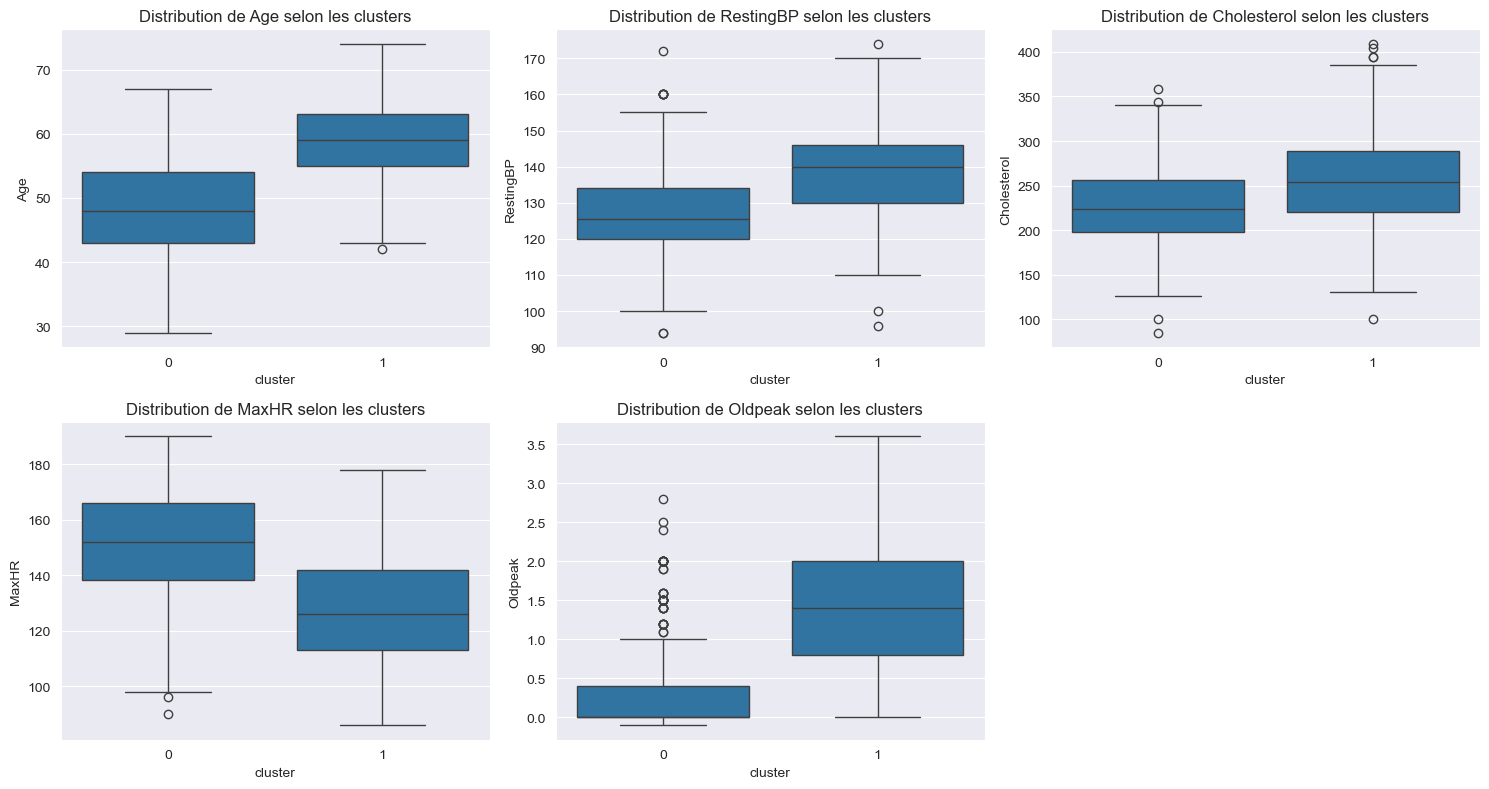

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import math

cols = X_cleaned_mixte.columns
n = len(cols)

# Choix de la grille (ex: 3 colonnes)
ncols = 3
nrows = math.ceil(n / ncols)

plt.figure(figsize=(5*ncols, 4*nrows))

for i, col in enumerate(cols, 1):
    plt.subplot(nrows, ncols, i)
    sns.boxplot(data=df_clusters, x="cluster", y=col)  # <- on enlève palette
    plt.title(f"Distribution de {col} selon les clusters")

plt.tight_layout()
#plt.savefig("figure/boxplots_clusters.png", dpi=300, bbox_inches='tight')
plt.show()


# Nous reprenons les variables catégorielles d'origine

In [21]:
df_cleaned_mixte.info()

<class 'pandas.core.frame.DataFrame'>
Index: 628 entries, 0 to 917
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                628 non-null    int64  
 1   RestingBP          628 non-null    int64  
 2   Cholesterol        628 non-null    int64  
 3   FastingBS          628 non-null    int64  
 4   MaxHR              628 non-null    int64  
 5   Oldpeak            628 non-null    float64
 6   HeartDisease       628 non-null    int64  
 7   Sex_F              628 non-null    bool   
 8   Sex_M              628 non-null    bool   
 9   ChestPainType_ASY  628 non-null    bool   
 10  ChestPainType_ATA  628 non-null    bool   
 11  ChestPainType_NAP  628 non-null    bool   
 12  ChestPainType_TA   628 non-null    bool   
 13  RestingECG_LVH     628 non-null    bool   
 14  RestingECG_Normal  628 non-null    bool   
 15  RestingECG_ST      628 non-null    bool   
 16  ExerciseAngina_N   628 non-null

In [22]:
df_cleaned_mixte['cluster'] = labels
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope',  ]  # adapte à ton dataset
for c in categorical_cols:
    chest_col = [col for col in df_cleaned_mixte.columns if col.startswith(f"{c}_")]
    df_cleaned_mixte[c] = df_cleaned_mixte[chest_col].idxmax(axis=1).str.replace(f"{c}_", "")
    df_cleaned_mixte = df_cleaned_mixte.drop(columns=chest_col)

# Visualisation de la répartition des variables catégorielles selon les clusters

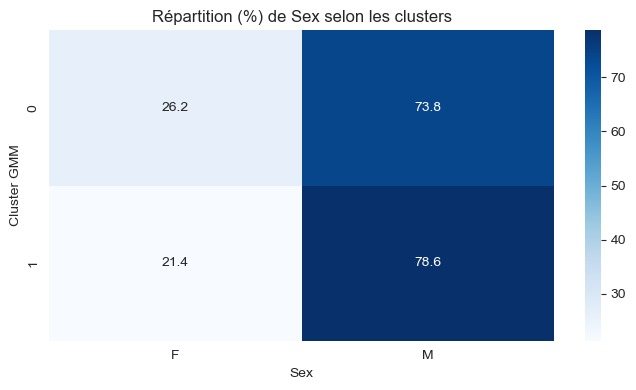

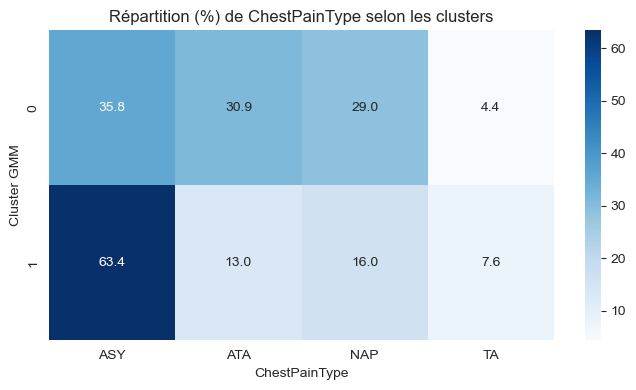

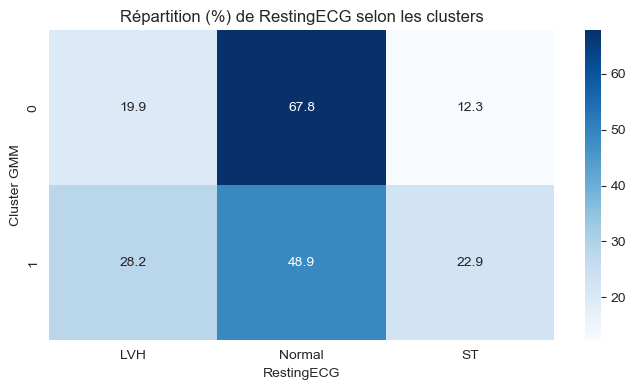

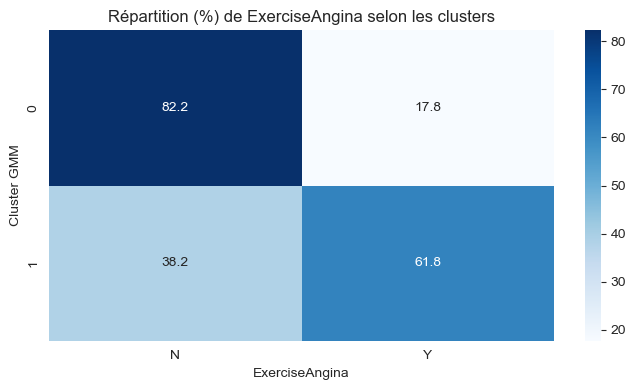

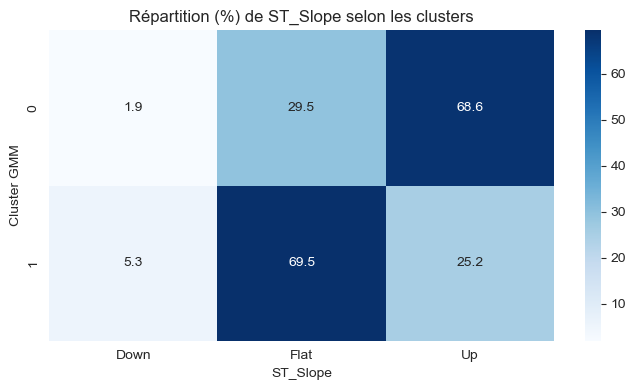

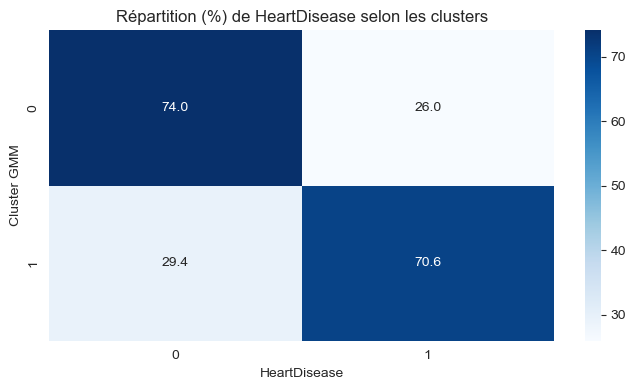

In [24]:
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']  # adapte selon ton dataset

for col in categorical_cols:
    plt.figure(figsize=(7,4))
    ct = pd.crosstab(df_cleaned_mixte['cluster'], df_cleaned_mixte[col], normalize='index') * 100
    sns.heatmap(ct, annot=True, fmt=".1f", cmap="Blues")
    plt.title(f"Répartition (%) de {col} selon les clusters")
    plt.ylabel("Cluster GMM")
    plt.xlabel(col)
    plt.tight_layout()
    #plt.savefig(f"figure/{col}_repartition_cluster.png", dpi=300, bbox_inches='tight')
    plt.show()


# Analyse des colonnes à valeurs continues qui influencent le plus les clusters

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
df_clusters['cluster'] = labels
X = df_clusters.drop(columns=['cluster'])
y = df_clusters['cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree = DecisionTreeClassifier(max_depth=4, random_state=42)  # max_depth=4 = interpretable
tree.fit(X_train, y_train)

feature_importances = pd.Series(tree.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\n==== FEATURE IMPORTANCE (Decision Tree) ====\n")
print(feature_importances)



==== FEATURE IMPORTANCE (Decision Tree) ====

Oldpeak        0.397341
Age            0.305745
Cholesterol    0.141117
MaxHR          0.104291
RestingBP      0.051507
dtype: float64


In [29]:
from sklearn.inspection import permutation_importance

perm_result = permutation_importance(tree, X_test, y_test, n_repeats=30, random_state=42)

perm_importance = pd.Series(perm_result.importances_mean, index=X.columns).sort_values(ascending=False)

print("\n==== PERMUTATION FEATURE IMPORTANCE ====\n")
print(perm_importance)


==== PERMUTATION FEATURE IMPORTANCE ====

Age            0.128924
Oldpeak        0.071958
MaxHR          0.046384
RestingBP      0.021517
Cholesterol    0.004056
dtype: float64


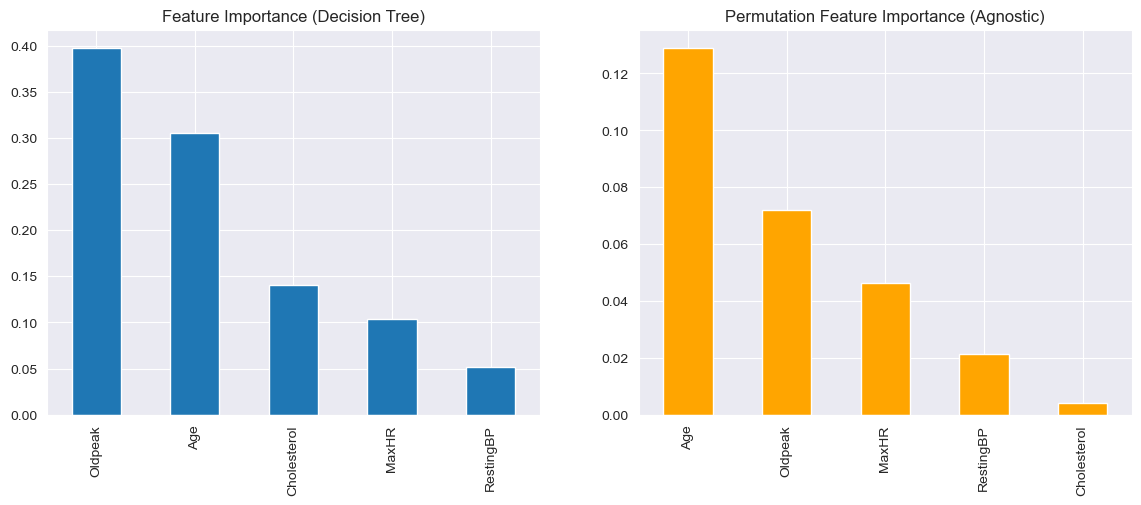

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
feature_importances.head(10).plot(kind='bar')
plt.title("Feature Importance (Decision Tree)")

plt.subplot(1, 2, 2)
perm_importance.head(10).plot(kind='bar', color='orange')
plt.title("Permutation Feature Importance (Agnostic)")
#plt.savefig("figure/feature_importance_tree.png", dpi=300, bbox_inches='tight')

plt.show()
